### Librerias Necesarias

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np 
from scipy.stats import norm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest

# configuracion diagrama de outliers
flp = dict(marker="o",
           markerfacecolor="red",
           markersize=5,
           linestyle="--",
           markeredgecolor="black")

# Prueba para científico de datos

## Parte 1 - Cargar datos y estadísticas básicas

En la carpeta ```Data``` encontrará un archivo llamado ```diamonds.csv```. Este archivo contiene información de 53940 diamantes. Dentro de la información disponible, está el precio, el color, el peso, etc. Puede consultar las características completas del dataset en [este enlace](https://www.kaggle.com/shivam2503/diamonds).

1. Cargue el archivo en un dataframe de pandas 
2. Use los metodos que conozca para describir las propiedades básicas de los datos. 

### 1. Lectura de datos

In [2]:
data = pd.read_csv("Data/diamonds.csv",  delimiter=",", index_col=0)
data

,carat,cut,color,clarity,depth,table,price,x,y,z
1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
...,...,...,...,...,...,...,...,...,...,...
53936,0.72,Ideal,D,SI1,60.8,57.0,2757,5.75,5.76,3.50
53937,0.72,Good,D,SI1,63.1,55.0,2757,5.69,5.75,3.61
53938,0.70,Very Good,D,SI1,62.8,60.0,2757,5.66,5.68,3.56
53939,0.86,Premium,H,SI2,61.0,58.0,2757,6.15,6.12,3.74


En primer lugar se debe verificar si la matriz de datos tiene datos faltantes

In [3]:
print(data.isnull().sum())

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64


Se debe notar que los valores que tengan cero o menor en las dimensiones son datos erroneos y no proveen información conrrecta al modelo que se construya, por lo tanto se borran estos valores de la base de datos 

In [4]:
data = data.drop(data.loc[(data["x"] == 0) & (data["x"] < 0)].index)
data = data.drop(data.loc[(data["y"] == 0) & (data["y"] < 0)].index)
data = data.drop(data.loc[(data["z"] == 0) & (data["z"] < 0)].index)

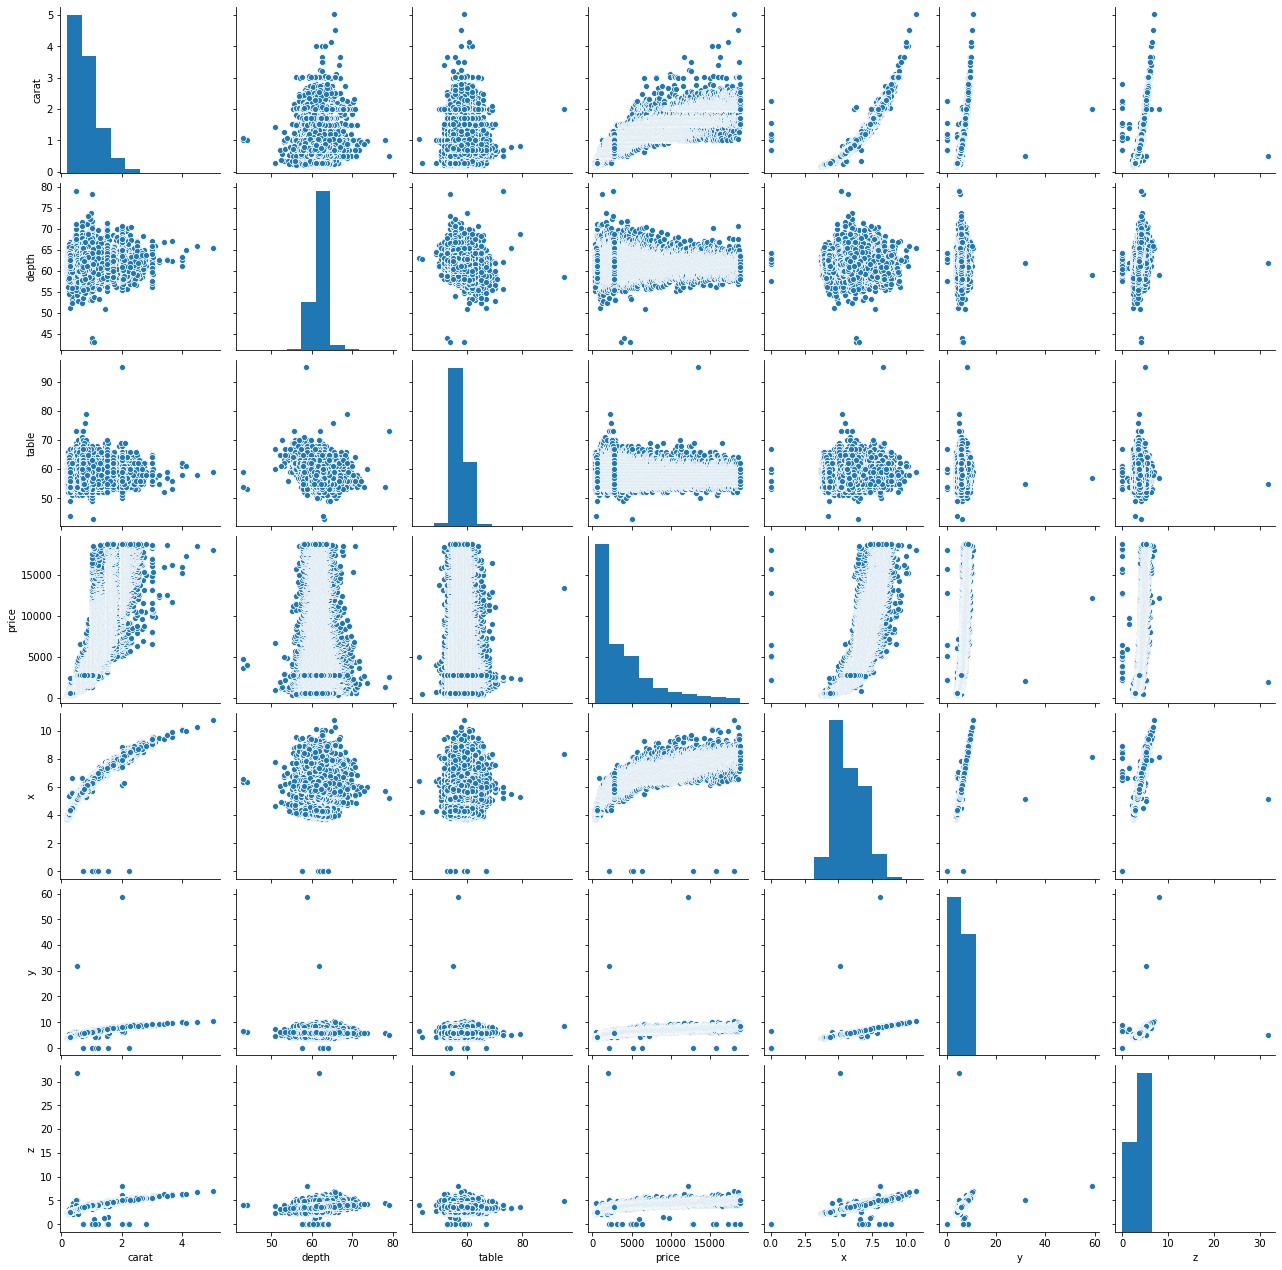

In [5]:
sns.pairplot(data[data.select_dtypes(include=["float64", "int64"]).columns])


Luego de esto hace un análisis de las variables dependiendo la tipología. Se empieza una revisión de las variables categóricas

# Variables Categóricas

## Cut 
Calidad del corte puede tomar 5 valores (Fair, Good, Very Good, Premium, Ideal), se muestra la distribución de la variable para ver su distribución. Adicional a esto se hace una codificación  para que los algoritmos puedan entender las variables categóricas 


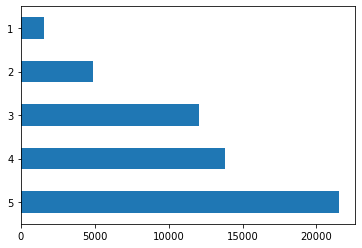

In [6]:
# Se usa un diccionario para relacionar la nueva codificacion
new_cut = {"Fair":1, 
           "Good":2,
           "Very Good":3,
           "Premium":4,
           "Ideal":5
          }
data["cut"] = data["cut"].map(new_cut)

data["cut"].value_counts().plot.barh()
X = data["cut"]

## Color

Calsificación del color por categorías, en donde se tiene una escala J(Peor) y  D(mejor). Se hace codificación para lso tipos de colores con número del 1 al 7 



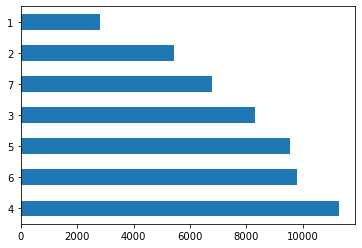

In [7]:
new_color = {"J":1,
             "I":2,
             "H":3,
             "G":4,
             "F":5,
             "E":6,
             "D":7
            }

data["color"] = data["color"].map(new_color)

data["color"].value_counts().plot.barh()
X = pd.concat([X, data["color"]], axis=1)

## Claridad 

medidad de claridad del diamante en donde la escala se entiende como I1(peor), SI2, SI1, VS2, VS1, VVS2, VVS1, IF(mejor). Se codifica la variable 

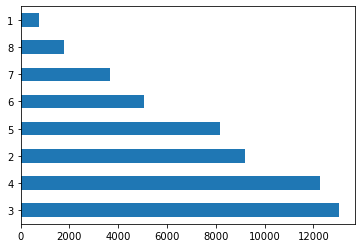

In [8]:
new_clarity = {"I1":1,
               "SI2":2,
               "SI1":3,
               "VS2":4,
               "VS1":5,
               "VVS2":6,
               "VVS1":7,
               "IF":8,
              }

data["clarity"] = data["clarity"].map(new_clarity)

data["clarity"].value_counts().plot.barh()
X = pd.concat([X, data["clarity"]], axis=1)

# variables Continuas 

## carat

Peso en quilates del diamante, definición ($1 ct = 0,2g$). En principio no se ve una distribución evidente, se lista la estadística descriptiva de la variable

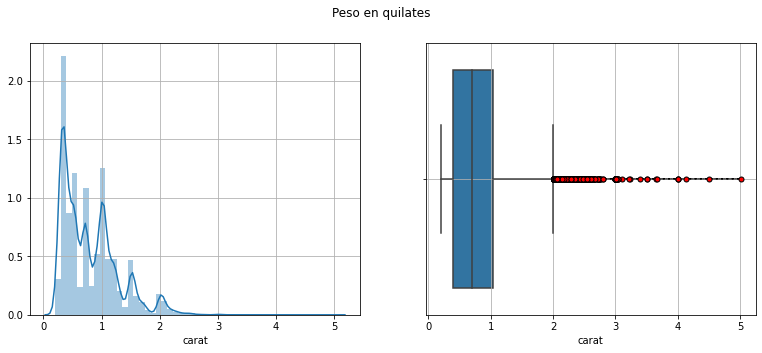

In [9]:
fig, ax =plt.subplots(1,2,figsize=(13,5))
fig.suptitle("Peso en quilates")
sns.distplot(data["carat"], ax=ax[0])
ax[0].grid(True)
sns.boxplot(x=pd.to_numeric(data["carat"]),flierprops=flp, ax = ax[1])
ax[1].grid(True)
data["carat"].describe()

X = pd.concat([X, data["carat"]], axis=1)


## depth 

porcentaje de profundidad total, que se calcula como 


$$T = \frac{2z}{x+y}$$

Puede ser una variable sintética de los datos

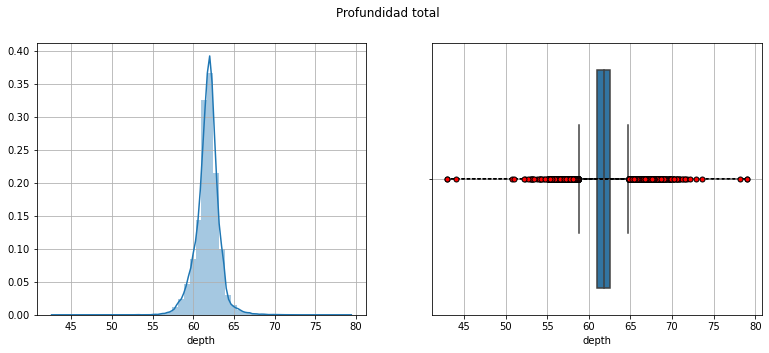

In [10]:
fig, ax =plt.subplots(1,2,figsize=(13,5))
fig.suptitle("Profundidad total")
sns.distplot(data["depth"], ax=ax[0])
ax[0].grid(True)
sns.boxplot(x=pd.to_numeric(data["depth"]),flierprops=flp, ax = ax[1])
ax[1].grid(True)
data["depth"].describe()

X = pd.concat([X, data["depth"]], axis=1)


## table

ancho de la parte superior del diamante en relación con el punto más ancho. Se puede evidenciar una distribución normal, salvo de valores atípicos que también se muestran.

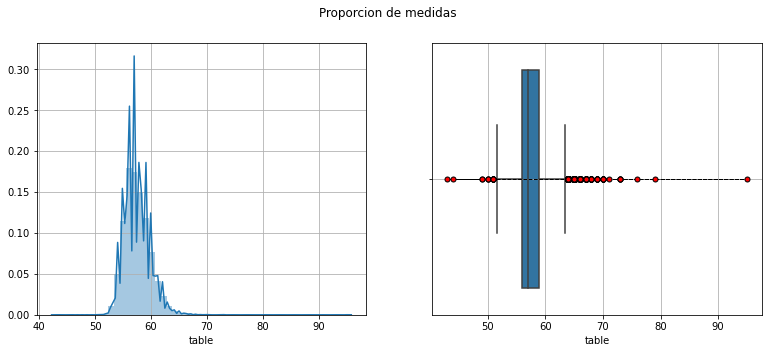

In [11]:
fig, ax =plt.subplots(1,2,figsize=(13,5))
fig.suptitle("Proporcion de medidas")
sns.distplot(data["table"], ax=ax[0])
ax[0].grid(True)
sns.boxplot(x=pd.to_numeric(data["table"]),flierprops=flp, ax = ax[1])
ax[1].grid(True)
data["table"].describe()

X = pd.concat([X, data["table"]], axis=1)


## Dimensiones

x,y,z Longitud en milimetros del diamante

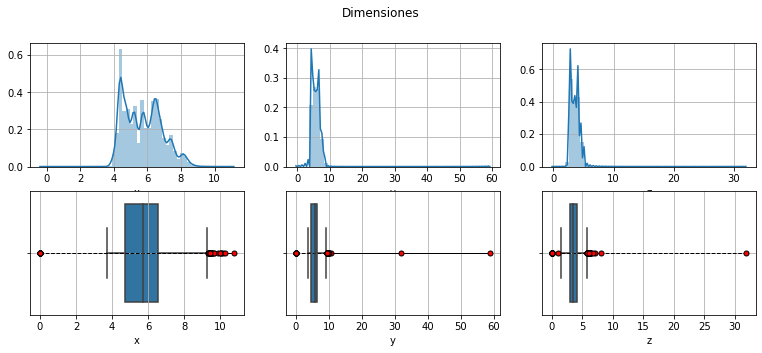

In [12]:
fig, ax =plt.subplots(2,3,figsize=(13,5))
fig.suptitle("Dimensiones")
sns.distplot(data["x"], ax=ax[0,0])
ax[0, 0].grid(True)
sns.distplot(data["y"], ax=ax[0,1])
ax[0, 1].grid(True)
sns.distplot(data["z"], ax=ax[0,2])
ax[0, 2].grid(True)
sns.boxplot(x=pd.to_numeric(data["x"]), flierprops=flp, ax=ax[1,0])
ax[1, 0].grid(True)
sns.boxplot(x=pd.to_numeric(data["y"]), flierprops=flp, ax=ax[1,1])
ax[1, 1].grid(True)
sns.boxplot(x=pd.to_numeric(data["z"]), flierprops=flp, ax=ax[1,2])
ax[1, 2].grid(True)



Se eliminan los outliers en el tamaño en cada dimensión 

In [13]:
# data = data.drop(data.loc[data.x < 2].index)
# data = data.drop(data.loc[data.y > 30].index)
# data = data.drop(data.loc[data.z > 25].index)
# identify outliers in the training dataset
iso = IsolationForest(contamination=0.1)     ############### ESTE ES EL ALGORITMO DE ELIMINACIÓN DE OUTLIERS ####################
outliers_dimension = iso.fit_predict(data[["x", "y", "z"]]) 

# # select all rows that are not outliers
outliers_dimension = outliers_dimension != -1
data = data[outliers_dimension] #Se elmininan todos los outliers de gasto_familiar


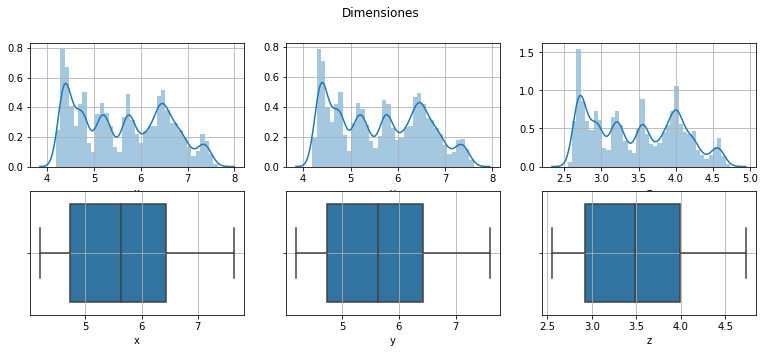

In [14]:
fig, ax =plt.subplots(2,3,figsize=(13,5))
fig.suptitle("Dimensiones")
sns.distplot(data["x"], ax=ax[0,0])
ax[0, 0].grid(True)
sns.distplot(data["y"], ax=ax[0,1])
ax[0, 1].grid(True)
sns.distplot(data["z"], ax=ax[0,2])
ax[0, 2].grid(True)
sns.boxplot(x=pd.to_numeric(data["x"]), flierprops=flp, ax=ax[1,0])
ax[1, 0].grid(True)
sns.boxplot(x=pd.to_numeric(data["y"]), flierprops=flp, ax=ax[1,1])
ax[1, 1].grid(True)
sns.boxplot(x=pd.to_numeric(data["z"]), flierprops=flp, ax=ax[1,2])
ax[1, 2].grid(True)

X = pd.concat([X, data["x"]], axis=1)
X = pd.concat([X, data["y"]], axis=1)
X = pd.concat([X, data["z"]], axis=1)


Podemos ver que estas variables pueden tener correlaciones especiales, dado que un diamante entre más grande sea más valor tiene en el mercado, veamos la matriz de correlacion de las dimensiones y el precio 

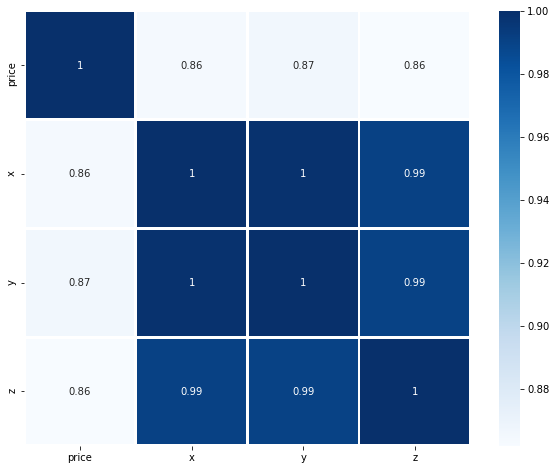

In [15]:
correlation = data[["price", "x", "y", "z"]].corr()

f, ax = plt.subplots(figsize=(10,8))
sns.heatmap(correlation, cmap="Blues", annot=True, linewidths=2)

Se puede ver como se ubica el volumen en un grafico tridimensional que indique el agrupamiento de volumenes

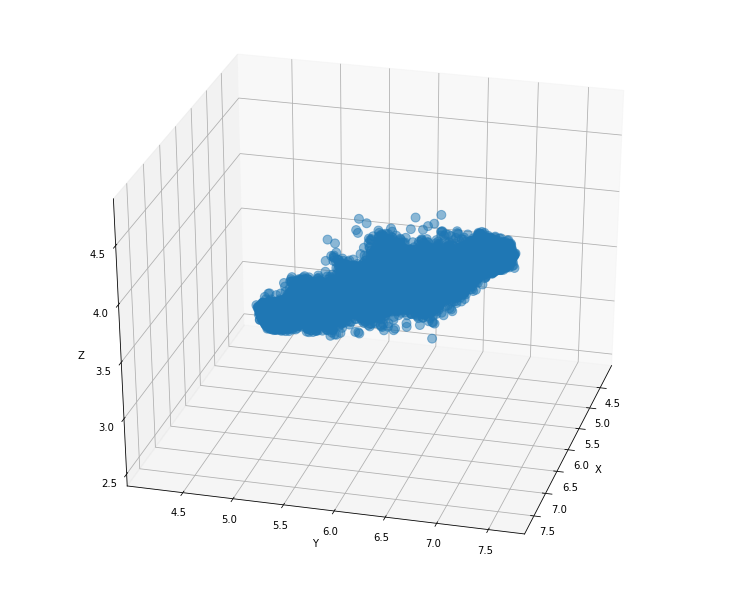

In [16]:
fig = plt.figure(figsize=(10,8))
ax = Axes3D(fig)

ax.scatter(xs=data["x"], ys=data["y"], zs=data["z"], s=80, alpha=0.5)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.view_init(elev=30, azim=15)

Se crea una variable adicional que reemplaze x,y,z. definiendo el volumen asi 

In [17]:
data["Volumen"] = data["x"]*data["y"]*data["z"]
X = pd.concat([X, data["Volumen"]], axis=1)
X = X.drop(["x", "y", "z"], axis=1)


Entonces se puede ver la relación entre el volumen y el precio, ademas de otras características 

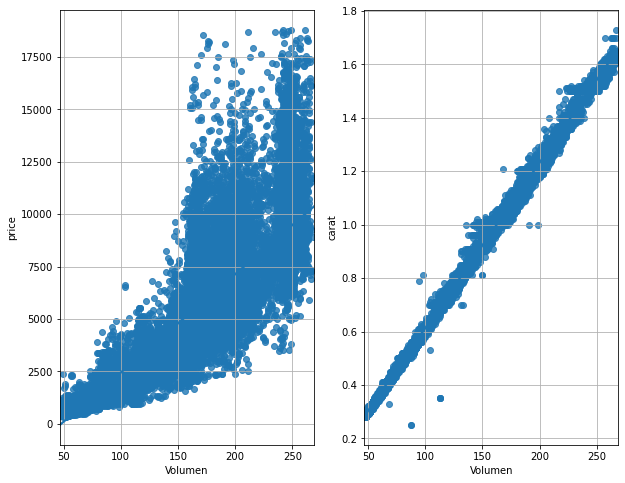

In [18]:
f, axes = plt.subplots(1,2, figsize=(10,8), sharex=False)
sns.regplot(x="Volumen", y="price", data=data, ax=axes[0], fit_reg=True)
sns.regplot(x="Volumen", y="carat", data=data, ax=axes[1], fit_reg=True)
axes[0].grid(True)
axes[1].grid(True)

# Variable objetivo

## Precio

Precio en dolares 


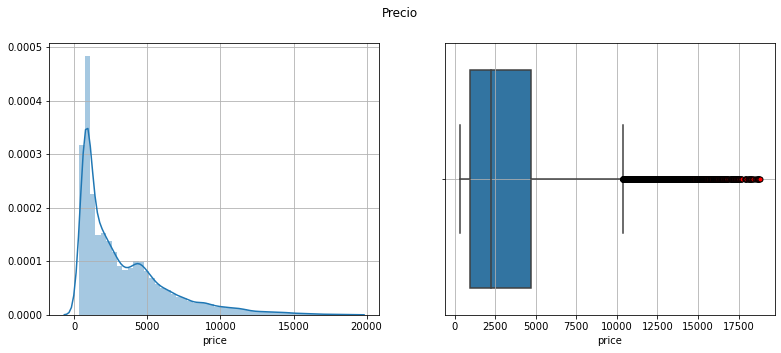

In [19]:
fig, ax =plt.subplots(1,2,figsize=(13,5))
fig.suptitle("Precio")
sns.distplot(data["price"], ax=ax[0])
ax[0].grid(True)
sns.boxplot(x=pd.to_numeric(data["price"]),flierprops=flp, ax = ax[1])
ax[1].grid(True)
data["price"].describe()

X = pd.concat([X, data["price"]], axis=1)


In [20]:
X.dropna(inplace=True)

## Parte 2 - Aprendizaje no supervisado

Usted desea encontrar estructura en los datos que le han sido dados. 
1. A partir del dataframe que cargó en el primer punto, use algún algoritmo de aprendizaje no supervisado para encontrar clusters de diamantes con propiedades similares. 
2. En una celda de markdown, describa una métrica/método que se pueda utilizar para evaluar la calidad de sus clusters.
3. Varie $k$ (la cantidad de clusters) de 1 a 10 y grafique su métrica en función de $k$
4. Qué $k$ describe mejor sus datos? 

___

Se usará K-means, un algoritmo de clustering no supervisado muy famoso, de los más simples. Este algoritmo busca minimizar una función obejtivo

$$J = \sum_{j=1}^{k}\sum_{i=1}^{n}\omega_{ij}|x_{i}^{(j)}-c_{j}|^{2}$$

donde se elige una distancia entre el dato $x_{i}$ y el cluster $c_{j}$, $\omega_{ij}$ es una función a trozos que determina la pertencia del punto a un determinado cluster. Es un indicador de la distancia de los puntos n en referencia al j-ésimo cluster.

En principio no se tiene clara la métrica para evaluar el rendimiento, dado que se requiere un $k$ de entrada y no lo aprende de los datos, no se tiene una teoría clara acerca de la cantidad de clusters para un determinado conjunto de datos. Lo que se pretende hacer es probar varios $k$ usando el método de codo. Este procedimiento da una buena idea de cual será una cantidad apropiada para $k$, usando alguna función de distancia que en este caso sera la suma de distancias al cuadrado entre los puntos de datos y los centroides de los clusters, se hace de esta manera porque k-means se basa implicitamente en distancias euclidianas por pares entre puntos de datos, es una medida multivariante es por esta razón que se elige esta métrica para minimizar esta distancia. se elige el $k$ que produzca el punto de inflexión en la curva de error en función de $k$. 



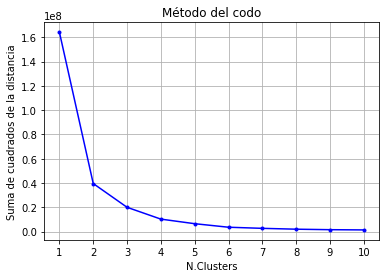

In [21]:
X_clust = np.array(X[["Volumen", "carat", "table"]])
k_fin = 10
x_data = np.arange(1, k_fin+1)
sse = []
for i in range(1, k_fin+1):
    #      
    km = KMeans(n_clusters = i, init = 'k-means++', max_iter = 100, n_init = 5, random_state = 0)
    km.fit(X_clust)
    sse.append(km.inertia_)


plt.plot(x_data, sse, "b.")
plt.plot(x_data, sse, "b-")
plt.title('Método del codo')
plt.xlabel('N.Clusters')
plt.xticks(x_data, x_data)
plt.ylabel('Suma de cuadrados de la distancia')
plt.grid(True)

Esta elección es un poco arbitraria, se elige $k=6$

In [22]:
km = KMeans(n_clusters = 6, random_state = 0)
y_means = km.fit_predict(X_clust)
centroids = km.cluster_centers_
print(centroids)

[[ 57.39304039   0.34907332  56.88909453]
 [160.28909438   0.99093307  58.08360706]
 [119.26549453   0.73175733  57.59460129]
 [244.80740338   1.51321757  57.85331971]
 [ 87.40810074   0.53282038  57.06057967]
 [194.64899186   1.1932592   57.48469445]]


Text(0.5, 0, 'Forma')

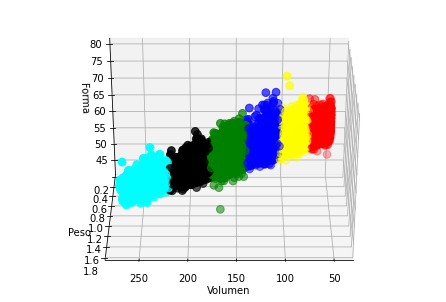

In [23]:
labels = km.predict(X_clust)

# Generacion de colores aleatorios dado un numero de cluster 
# dado


colors = ["red", 
          "green", 
          "blue", 
          "cyan", 
          "yellow",
          "black",
#           "brown",
#           "darkorange",
#           "olive",
#           "magenta"
         ]

asignar = []

for row in labels:
    asignar.append(colors[row])
    

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X_clust[:, 0], X_clust[:, 1], X_clust[:, 2], c=asignar, s=60)
ax.scatter(centroids[:, 0], centroids[:, 1],centroids[:, 2], c="magenta" ,marker="o", s=60)
ax.view_init(elev=30, azim=90)
ax.set_xlabel("Volumen")
ax.set_ylabel("Peso")
ax.set_zlabel("Forma")


Se produjeron 6 clusters con los datos de los diamantes, agrupados por sus características físicas teniendo en cuenta el volumen, el peso en quilates y la relación entre su superficie y forma. Veamos graficas bidimensionales para clarificar las relaciones

### Relación entre el volumen y el peso

Text(0, 0.5, 'Peso')

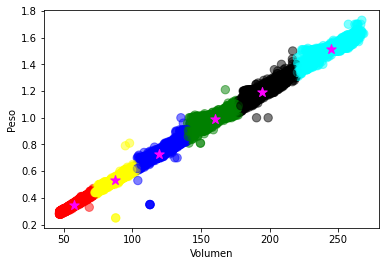

In [24]:
f1 = data['Volumen'].values
f2 = data['carat'].values
 
plt.scatter(f1, f2, c=asignar, s=70, alpha=0.5)
plt.scatter(centroids[:, 0], centroids[:, 1], marker='*', c="magenta", s=100)
plt.xlabel("Volumen")
plt.ylabel("Peso")

Es casi evidente la relación entre más voluminoso el diamante es más pesado, veamos cuantos diamantes existen en cada grupo teniendo en cuenta el volumen, el peso y la forma

In [25]:
copy = pd.DataFrame()
copy["label"] = labels
X_VP = pd.DataFrame()
X_VP["color"] = colors
X_VP["cantidad"] = copy.groupby("label").size()
X_VP

,color,cantidad
0,red,15561
1,green,9771
2,blue,7270
3,cyan,2932
4,yellow,7695
5,black,5317


### Relación entre volumen y la forma 

Text(0, 0.5, 'proporcion de Forma')

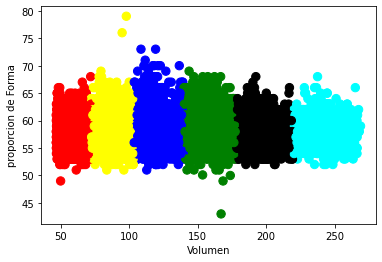

In [26]:
f1 = data['Volumen'].values
f2 = data['table'].values
 
plt.scatter(f1, f2, c=asignar, s=70)
# plt.scatter(centroids[:, 0], centroids[:, 1], marker='*', c=colors, s=100)
plt.xlabel("Volumen")
plt.ylabel("proporcion de Forma")

### Relación entre la forma y el peso

Text(0, 0.5, 'proporcion de Forma')

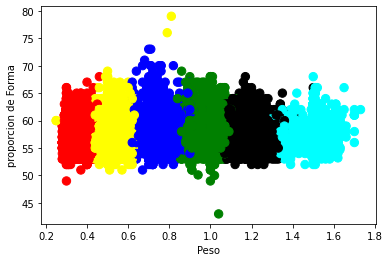

In [27]:
f1 = data['carat'].values
f2 = data['table'].values
 
plt.scatter(f1, f2, c=asignar, s=70)
# plt.scatter(centroids[:, 0], centroids[:, 1], marker='*', c=colors, s=100)
plt.xlabel("Peso")
plt.ylabel("proporcion de Forma")

## Parte 3 - Reducción de dimensionalidad y regresión

Usted quiere predecir el precio del diamante a partir de sus características (toda columna en el dataset que no sea el precio). Sin embargo, tiene la intuición que varias columnas son redundantes - es decir - hay columnas que no aportan información nueva. 

1. Realice una reducción de dimensionalidad de los datos para evitar tener información redundante. Procure que en este nuevo espacio se explique por lo menos el 90% de la varianza de los datos.
2. En una celda de markdown, describa una métrica que se pueda utilizar para evaluar la calidad de su regresión y su habilidad para explicar los datos. 
3. Parta los datos en un conjunto de entrenamiento y otro de evaluación. 
3. Sobre este nuevo espacio, entrene un algoritmo de regresión para predecir el precio de los diamantes sobre el conjunto de entrenamiento. Evalue su algoritmo con su métrica sobre el conjunto de test. ¿Qué tan bien le va a su algoritmo? ¿Lo llevaría a producción? ¿Por qué? 


In [28]:
# Respuesta a la parte 3 




## Parte 4 - clasificación

En la carpeta ```Data``` hay un archivo llamado ```emotions.csv``` que contiene informacion sobre las ondas electromagneticas emitidas por los cerebros de 2 pacientes. Hay un total de 2549 columnas con 2132 entradas. Su trabajo es predecir el estado de ánimo de la persona (la columna label): NEUTRAL, POSITIVE o NEGATIVE a partir de las otras columnas. Puede ver una descripción extensa del dataset [aquí](https://www.kaggle.com/birdy654/eeg-brainwave-dataset-feeling-emotions). 

Implemente el pipeline que considere necesario para llevar a cabo esta tarea. Es libre de escoger las herramientas y los métodos de clasificación que desee siempre y cuando cumpla lo siguiente:

1. Implemente por lo menos 2 algoritmos de clasificación. 
2. Grafique la matriz de confusión y las curvas de precisión y cobertura para cada algoritmo. 

Compare los resultados de sus clasificadores. 

3. ¿Cuál algoritmo es mejor? 
4. ¿Considera que el mejor algoritmo es suficiente para entrar a producción? ¿Por qué? ¿Por qué no? 


In [29]:
# Respuesta a la parte 4



## Parte 5 - Despliegue

Despliegue el mejor clasificador de la etapa anterior en un endpoint. El endpoint debe procesar el objeto JSON del *body* de un POST request. El formato del objeto JSON es el siguiente:

```
{"input":[val1,val2,val3, ... ,val2548]}

```
El orden de los valores corresponde al orden de las columnas del archivo `emotions.csv`. La lista tiene 2548 valores que corresponden a los 2548 que su clasificador debe tomar como input. 

El endpoint debe retornar un json de la siguiente forma si la petición fue exitosa: 

```
{"output":"clasfOutput"}
```

Donde "clasfOutput" corresponde a la predicción del clasificador (NEUTRAL, POSITIVE o NEGATIVE).

In [30]:
# Respuesta a la parte 5 (url del endpoint)


